<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [83]:
# Your Code Here
data = pd.read_csv("winequality-red.csv", sep=';')
data.loc[:, 'quality_cat'] = (data.loc[:, 'quality'] > 5).astype(int)
data = data.drop('quality', axis=1)
X = data.drop('quality_cat', axis=1)
y = data.quality_cat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print X.shape
print y_test.shape

(1599, 11)
(320,)


#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью:
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [104]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve
    
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

Построим график усредненной оценки качества roc-auc на кросс-валидации при различных d от 0 до 25 и подберём самую эффективную глубину дерева:

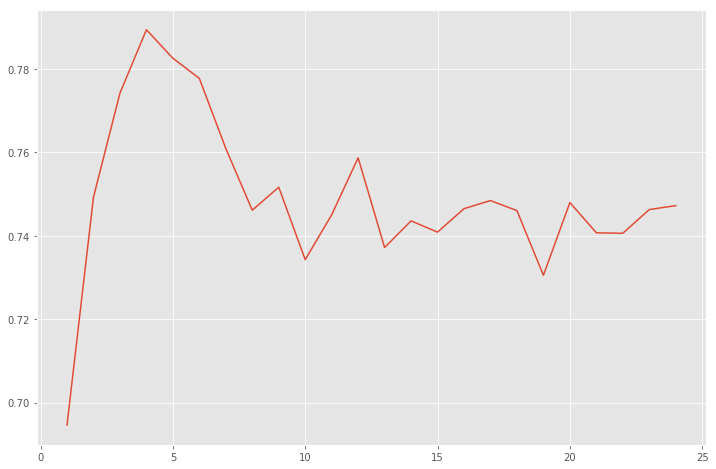

In [105]:
# Your Code Here
depthRange=range(1, 25)
scoremeans=[]
for i in depthRange:
    scoremeans.append(cross_val_score(DecisionTreeClassifier(max_depth=i), X_train, y_train, scoring='roc_auc', cv = 5).mean())

plt.plot(depthRange,scoremeans)

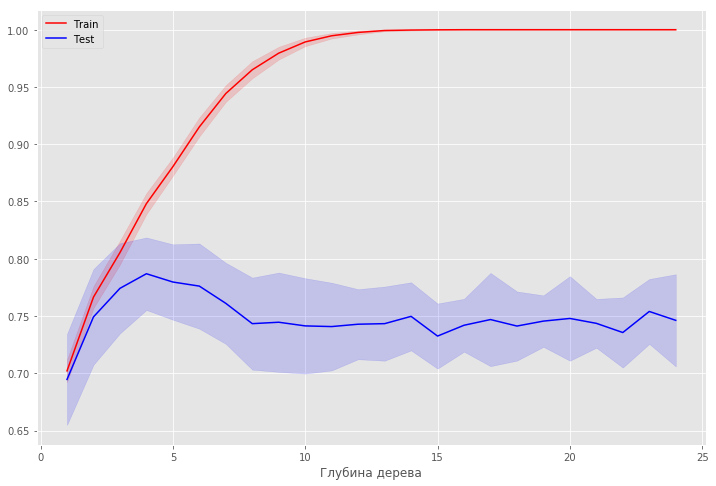

In [122]:
model = DecisionTreeClassifier()
train_scores, test_scores = validation_curve(model,X_train,y_train,'max_depth',depthRange, scoring='roc_auc', cv = 5)

train_scores_mean,test_scores_mean=train_scores.mean(axis=1),test_scores.mean(axis=1)
train_scores_std,test_scores_std=train_scores.std(axis=1),test_scores.std(axis=1)

plt.plot(depthRange,train_scores_mean,c='r',label="Train")
plt.fill_between(depthRange,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,color='r',alpha=0.15)
plt.plot(depthRange,test_scores_mean,c='b',label="Test")
plt.fill_between(depthRange,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,color='b',alpha=0.15)
plt.legend()
plt.xlabel(u'Глубина дерева')
plt.show()

Берём пять - довольно справедливое значение глубины, переобучения не должно быть. Будет сильно переобучаться - уменьшу до 4-3.

Посоветовали выставить cv на значение 5 (вместо 3 по умолчанию) - стало видно, что с глубиной дерева в 4 всё лучше.


In [107]:
bestDepth=4

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [108]:
# Your Code Here
cl = DecisionTreeClassifier (max_depth=4, random_state=42)
cl.fit(X_train, y_train)
fi = cl.feature_importances_
feature_colums = data.columns[data.columns != 'quality_cat']
#print feature_colums
#print fi
sorted_cols = [(x,y) for (y,x) in sorted(zip(fi,feature_colums),reverse=True)]
for col in sorted_cols:
    print col

('alcohol', 0.54335556010637265)
('sulphates', 0.2180038443980869)
('total sulfur dioxide', 0.10214649062609693)
('volatile acidity', 0.071776872037399769)
('pH', 0.033394997923790137)
('density', 0.031322234908253636)
('residual sugar', 0.0)
('free sulfur dioxide', 0.0)
('fixed acidity', 0.0)
('citric acid', 0.0)
('chlorides', 0.0)


Получили результат, описанный в одной из прошлых домашек (предисловие про вино). Круто:)

#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

precision:  0.741758241758
recall:  0.754189944134
f1 score:  0.747922437673
accuracy score:  0.715625


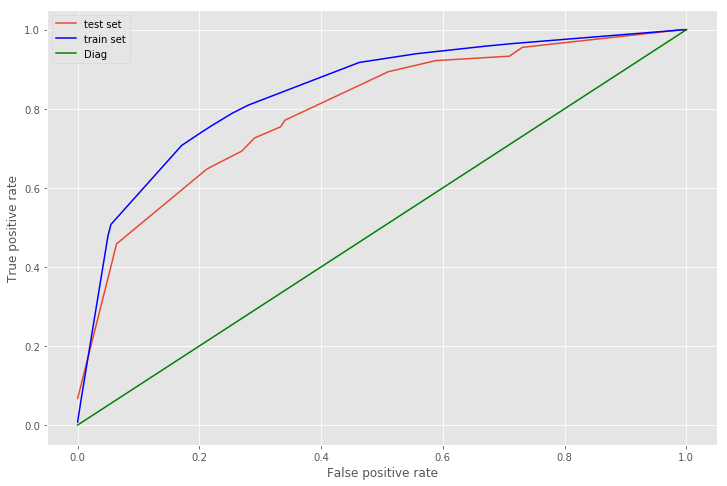

In [123]:
# Your Code Here
from sklearn.metrics import roc_curve
from sklearn import metrics
res_for_test_proba = cl.predict_proba(X_test)
res_for_train_proba = cl.predict_proba(X_train)
res_for_test = cl.predict (X_test)
res_for_train = cl.predict (X_train)
# res_for_test
# print test['quality_cat'].values
test_proba = [y for (x,y) in res_for_test_proba]
train_proba = [y for (x,y) in res_for_train_proba]
fpr_test, tpr_test , thresholds_test= roc_curve(y_test, test_proba)
fpr_train, tpr_train , thresholds_train= roc_curve(y_train, train_proba)
# roc_test

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot (fpr_test, tpr_test)
plt.plot (fpr_train, tpr_train,color='b')
plt.plot ([0,1], [0,1], color='g')
plt.legend(["test set","train set","Diag"])
R = metrics.recall_score (y_test,res_for_test)
P = metrics.precision_score (y_test,res_for_test)
print "precision: ",P
print "recall: ",R
F = metrics.f1_score (y_test,res_for_test)
print "f1 score: ",F
A = metrics.accuracy_score(y_test,res_for_test)
print "accuracy score: ", A

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [113]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [119]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')
df_wine.loc[:, 'quality'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
data=df_wine.values
X,Y=data[:,:-1],data[:,-1]

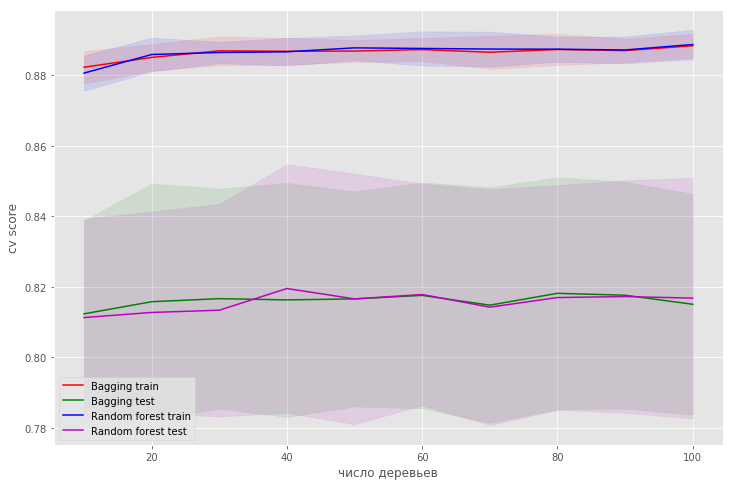

In [121]:
# Your Code Here
model = DecisionTreeClassifier(max_depth=bestDepth)
baggingModel=BaggingClassifier(base_estimator=model)
randomForestModel=RandomForestClassifier(max_depth=bestDepth)
modelCountRange=range(10,101, 10);
btrss,btess=validation_curve(baggingModel,X,Y,'n_estimators',modelCountRange, cv=5, scoring='roc_auc')
rftrss,rftess=validation_curve(baggingModel,X,Y,'n_estimators',modelCountRange, cv=5, scoring='roc_auc')

meanBtrss,meanBtess,meanRftrss,meanRftess=btrss.mean(axis=1),btess.mean(axis=1),rftrss.mean(axis=1),rftess.mean(axis=1)
stdBtrss,stdBtess,stdRftrss,stdRftess=btrss.std(axis=1),btess.std(axis=1),rftrss.std(axis=1),rftess.std(axis=1)

plt.plot(modelCountRange,meanBtrss,color='r',label="Bagging train")
plt.plot(modelCountRange,meanBtess,color='g',label="Bagging test")
plt.plot(modelCountRange,meanRftrss,color='b',label="Random forest train")
plt.plot(modelCountRange,meanRftess,color='m',label="Random forest test")

plt.fill_between(modelCountRange,meanBtrss-stdBtrss,meanBtrss+stdBtrss,color='r',alpha=0.1)
plt.fill_between(modelCountRange,meanBtess-stdBtess,meanBtess+stdBtess,color='g',alpha=0.1)
plt.fill_between(modelCountRange,meanRftrss-stdRftrss,meanRftrss+stdRftrss,color='b',alpha=0.1)
plt.fill_between(modelCountRange,meanRftess-stdRftess,meanRftess+stdRftess,color='m',alpha=0.1)
plt.legend()
plt.xlabel(u'число деревьев')
plt.ylabel('cv score')

Видно, что на train-сэте разброс поменьше и качество повыше, это честно.
Приятно, что модель не переобучилась (как это было с глубиной дерева в 5 - тут картинка лучше)

Выведу ещё один график, для души:

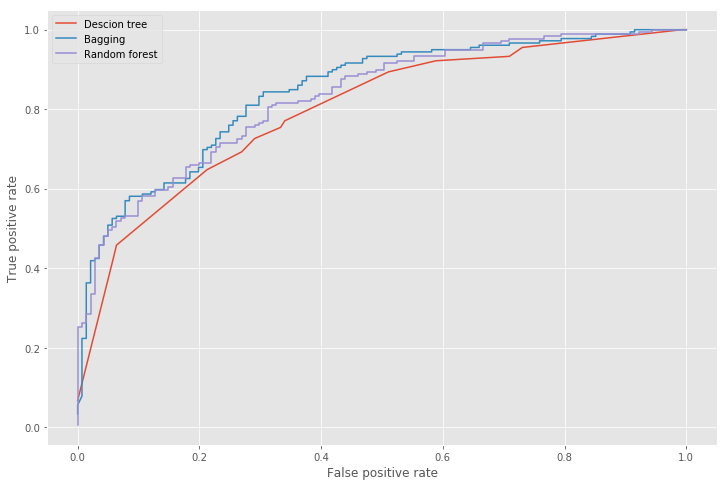

In [117]:
from sklearn.metrics import roc_curve

model = DecisionTreeClassifier(max_depth=bestDepth).fit(X_train,y_train)
baggingModel=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=bestDepth),n_estimators=30).fit(X_train,y_train)
randomForestModel=RandomForestClassifier(max_depth=bestDepth,n_estimators=30).fit(X_train,y_train)

pred_tree=model.predict_proba(X_test)
pred_bagging=baggingModel.predict_proba(X_test)
pred_randForest=randomForestModel.predict_proba(X_test)

tree_roc=roc_curve(y_test,pred_tree[:,1])
bagging_roc=roc_curve(y_test,pred_bagging[:,1])
randForest_roc=roc_curve(y_test,pred_randForest[:,1])

plt.plot(tree_roc[0],tree_roc[1])
plt.plot(bagging_roc[0],bagging_roc[1])
plt.plot(randForest_roc[0],randForest_roc[1])
plt.legend(["Descion tree","Bagging","Random forest"])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

По этому графику случайный лес и бэггинг выглядят сильно лучше обычного решающего дерева


####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [124]:
# Your Code Here
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
forest = RandomForestClassifier()
param_grid = {'n_estimators': range(10,101,10), 'max_depth': range(1,30)}
grid= GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='roc_auc')

grid.fit(X=X_train, y=y_train)
print("The best params:\nMax depth: "+str(grid.best_params_["max_depth"])+"\nTree count: "+str(grid.best_params_["n_estimators"]))

The best params:
Max depth: 14
Tree count: 60


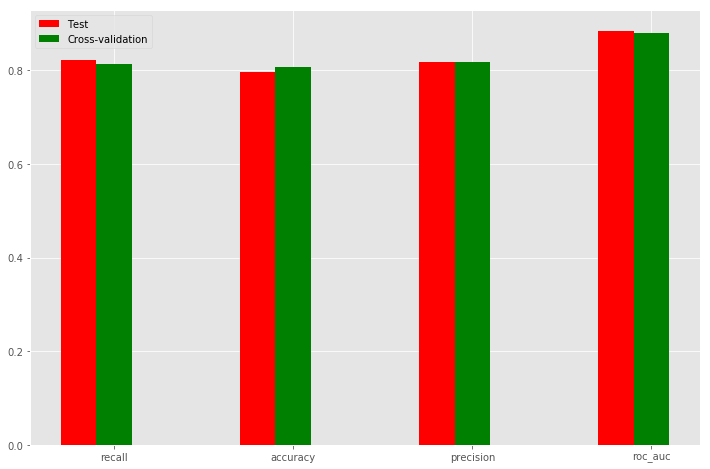

In [125]:
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,precision_score

prediction=grid.best_estimator_.predict(X_test)
test_prprediction=grid.best_estimator_.predict_proba(X_test)[:,1]

test_scores={}
test_scores["roc_auc"]=roc_auc_score(y_test, test_prprediction)
test_scores["accuracy"]=accuracy_score(y_test,prediction)
test_scores["recall"]=recall_score(y_test,prediction)
test_scores["precision"]=precision_score(y_test,prediction)

cross_val_scores={}
cross_val_scores["roc_auc"]=cross_val_score(grid.best_estimator_, X_train, y_train,cv=5, scoring='roc_auc').mean()
cross_val_scores["accuracy"]=cross_val_score(grid.best_estimator_, X_train, y_train,cv=5, scoring='accuracy').mean()
cross_val_scores["recall"]=cross_val_score(grid.best_estimator_, X_train, y_train,cv=5, scoring='recall').mean()
cross_val_scores["precision"]=cross_val_score(grid.best_estimator_, X_train, y_train,cv=5, scoring='precision').mean()


width=0.2
ind=np.arange(len(test_scores))
plt.bar(ind,test_scores.values(),width,label="Test",color='r')
plt.bar(ind+width,cross_val_scores.values(),width,label="Cross-validation",color='g')
plt.xticks(ind + width, test_scores.keys())
plt.legend()

Грид-сёрч отработал отлично, какое счастье: качество высокое, ничего не переобучилось, красота, только долговато на моём компьютере